## Environment

In [9]:
#Using latest version of LangChain
import langchain
langchain.__version__

'0.3.18'

### Install Packages

In [2]:
# !pip install langchain_community tiktoken langchain-groq langchainhub chromadb langchain
# !pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

### API Keys

In [10]:
import os, json, re, getpass
from dotenv import load_dotenv

load_dotenv(".env", override=True)

False

In [11]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [12]:
#Check for Groq API Key
_set_env("GROQ_API_KEY")

GROQ_API_KEY: ··········


In [13]:
#Check for Tavily API Key
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


In [14]:
#Check for LangSmith tracing
_set_env("LANGSMITH_TRACING")

#Check for LangChain API Key - LangSmith
_set_env("LANGSMITH_API_KEY")

#Check for LangChain endpoint
_set_env("LANGSMITH_ENDPOINT")

os.environ["LANGSMITH_PROJECT"] = "GenAI_Ex3_4_Kunal_Deshmukh"

LANGSMITH_TRACING: ··········
LANGSMITH_API_KEY: ··········
LANGSMITH_ENDPOINT: ··········


### Libraries

In [15]:
# !pip install langchain_huggingface
# !pip install langchain_chroma
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma

from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from pydantic import BaseModel, Field

from pprint import pprint

## Selecting Components

### Chat Model

In [16]:
llm = ChatGroq(model="llama3-8b-8192") #llama3-8b-8192, llama-3.1-8b-instant, llama3-groq-8b-8192-tool-use-preview, llama3-groq-70b-8192-tool-use-preview

In [18]:
llm.invoke("Hello, World!")

AIMessage(content='Hello, World!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 5, 'prompt_tokens': 14, 'total_tokens': 19, 'completion_time': 0.004166667, 'prompt_time': 0.00223918, 'queue_time': 0.144786388, 'total_time': 0.006405847}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_6a6771ae9c', 'finish_reason': 'stop', 'logprobs': None}, id='run-f0069043-6f61-4f3a-934c-8739b1cc8b18-0', usage_metadata={'input_tokens': 14, 'output_tokens': 5, 'total_tokens': 19})

### Embedding Model

In [19]:
# !pip install sentence-transformers
embed_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Vector Store

In [20]:
vector_store = Chroma(embedding_function=embed_model)

## Retriever

First, we index 3 pages.

In [21]:
urls = [
    "https://www.jioinstitute.edu.in/academics/artificial-intelligence-data-science",
    "https://www.jioinstitute.edu.in/academics/study-abroad",
    "https://www.jioinstitute.edu.in/experiential-learning"
]

In [22]:
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

In [23]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [24]:
# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embed_model,
)

In [25]:
retriever = vectorstore.as_retriever()

## Define Test Questions

In [118]:
# STEP 0: Adding a new query for YouTube search tool
youtube_search_query = "I want few links to good YouTube videos on Generative AI crash course"

In [27]:
question_search = "Which players in IPL 2025 are expected to draw significant bids"

In [28]:
question_doc = "What are the highlights of the PGP in Data Science and AI course at Jio Institute"

## LLMs

### Router

In [29]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

In [30]:
# Data model
## STEP 1: Adding the YouTube search tool to Literal
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    # Updated to include 'youtube_search' as a routing option
    datasource: Literal["vectorstore", "web_search", "youtube_search"] = Field(
        ...,
        description="Given a user question, choose to route it to web search, a vectorstore, or YouTube search.",
    )

In [31]:
# LLM with function call
structured_llm_router = llm.with_structured_output(RouteQuery)

In [32]:
##STEP 2: MODIFY PROMPT to route to your new tool accordingly
# Updated Prompt to include YouTube search
system = """You are an expert at routing a user question to a vectorstore, web search, or YouTube search.
The vectorstore contains documents related to Jio Institute courses, including Data Science and AI.
Use the vectorstore for questions specifically about information present in those documents.
Use YouTube search for queries that explicitly ask for video content or specific YouTube videos.
For general queries or those not found in the documents, use web-search.
Only return the datasource as 'vectorstore', 'web_search', or 'youtube_search' and nothing else."""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

In [33]:
question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": question_search}
    )
)
print(question_router.invoke({"question": question_doc}))
print(question_router.invoke({"question": youtube_search_query})) # for our new tool - YouTube search

datasource='web_search'
datasource='vectorstore'
datasource='youtube_search'


### Retrieval Grader

In [34]:
# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

In [35]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

In [36]:
# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    For youtube links in the document always grade as relevant"""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [37]:
retrieval_grader = grade_prompt | structured_llm_grader
docs = retriever.invoke(question_doc)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question_doc, "document": doc_txt}))

binary_score='yes'


In [38]:
docs

[Document(id='4e85d294-2810-4ca4-a1c2-e0a9a9167d91', metadata={'description': "Explore Jio Institute's artificial intelligence course offerings. Dive into the world of AI and data science with our cutting-edge programmes. Apply now!", 'language': 'en', 'source': 'https://www.jioinstitute.edu.in/academics/artificial-intelligence-data-science', 'title': 'PGP in Artificial Intelligence & Data Science - Jio Institute'}, page_content='Jio Institute has formulated a seamless digital admissions process to apply to its academic programmes. We invite applications from meritorious students from accross the globe. Eligibility for PGP in Artificial Intelligence & Data Science :A four-year undergraduate degree or its equivalent, in the field of Engineering/Science/ Mathematics and Statistics with minimum 50 per cent or equivalent CGPA. A postgraduate degree (if the undergraduate degree is of three years) in the field of'),
 Document(id='9740abdd-79f2-496c-83dd-12cf5c628877', metadata={'description'

### Generate

In [39]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

In [40]:
# Prompt
prompt = hub.pull("rlm/rag-prompt")

In [41]:
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [42]:
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [43]:
# Chain
rag_chain = prompt | llm | StrOutputParser()

In [54]:
# Run
generation = rag_chain.invoke({"context": docs, "question": question_doc})
print(generation)

The PGP in Data Science and AI course at Jio Institute has a comprehensive and rigorous curriculum that covers foundation and advanced courses to train future-ready full-stack data scientists and AI architects. The program provides students with immersive learning through live projects and opportunities to acquire crucial contemporary life skills. Additionally, students can participate in study abroad programs at partner universities outside India.


### Hallucination Grader

In [48]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

In [49]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

In [50]:
# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts. \n
     Be careful of one exception - if the LLM generation contains youtube video links always give binary score of 'yes'."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

In [51]:
hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

In [52]:
docs

[Document(id='4e85d294-2810-4ca4-a1c2-e0a9a9167d91', metadata={'description': "Explore Jio Institute's artificial intelligence course offerings. Dive into the world of AI and data science with our cutting-edge programmes. Apply now!", 'language': 'en', 'source': 'https://www.jioinstitute.edu.in/academics/artificial-intelligence-data-science', 'title': 'PGP in Artificial Intelligence & Data Science - Jio Institute'}, page_content='Jio Institute has formulated a seamless digital admissions process to apply to its academic programmes. We invite applications from meritorious students from accross the globe. Eligibility for PGP in Artificial Intelligence & Data Science :A four-year undergraduate degree or its equivalent, in the field of Engineering/Science/ Mathematics and Statistics with minimum 50 per cent or equivalent CGPA. A postgraduate degree (if the undergraduate degree is of three years) in the field of'),
 Document(id='9740abdd-79f2-496c-83dd-12cf5c628877', metadata={'description'

In [55]:
generation

'The PGP in Data Science and AI course at Jio Institute has a comprehensive and rigorous curriculum that covers foundation and advanced courses to train future-ready full-stack data scientists and AI architects. The program provides students with immersive learning through live projects and opportunities to acquire crucial contemporary life skills. Additionally, students can participate in study abroad programs at partner universities outside India.'

### Answer Grader

In [56]:
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

In [57]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeAnswer)

In [58]:
# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question. \n
     Take care of the exception where if the LLM generation contains the term 'videos' or URLs from youtube.com always give binary score of 'yes'"""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

In [59]:
answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question_doc, "generation": generation})

GradeAnswer(binary_score='yes')

In [60]:
print(question_doc, "\n\n", generation)

What are the highlights of the PGP in Data Science and AI course at Jio Institute 

 The PGP in Data Science and AI course at Jio Institute has a comprehensive and rigorous curriculum that covers foundation and advanced courses to train future-ready full-stack data scientists and AI architects. The program provides students with immersive learning through live projects and opportunities to acquire crucial contemporary life skills. Additionally, students can participate in study abroad programs at partner universities outside India.


### Question Re-writer

In [61]:
# Prompt
system = """You are a question re-writer that converts an input question to a better version that is optimized \n
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning. \n
     Only return the rewritten question and nothing else."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

In [62]:
question_doc

'What are the highlights of the PGP in Data Science and AI course at Jio Institute'

In [63]:
question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question_doc})

'What are the key takeaways, modules, and curriculum details of the Postgraduate Program in Data Science and AI offered by Jio Institute?'

## Tools

### Search Tool

In [64]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [66]:
##STEP 3: Adding new YouTube search tool

# # installing the youtube search library for youtube tool functionality
# !pip install youtube-search

from langchain_community.tools import YouTubeSearchTool

youtube_search_tool = YouTubeSearchTool()

In [75]:
# testing the tool with some random query
res = youtube_search_tool._search('LangChain tutorial', num_results = 2)
print(res)

['https://www.youtube.com/watch?v=aywZrzNaKjs&pp=ygUSTGFuZ0NoYWluIHR1dG9yaWFs', 'https://www.youtube.com/watch?v=nAmC7SoVLd8&pp=ygUSTGFuZ0NoYWluIHR1dG9yaWFs']


## Construct the Graph

Capture the flow in as a graph.

### Define Graph State

We will define a graph.

A `state` object that it passes around to each node.

Our state will have 3 attributes - `question`, `generation` and `documents`.

Each node in our graph will update to it.

In [76]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

### Define Graph Flow

We can lay out an agentic RAG graph like this:

* The state has a set of attributes
* Each node will update the state
* Conditional edges decide which node to visit next

#### Nodes

In [77]:
from langchain.schema import Document

In [78]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [79]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

In [80]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}

In [81]:
question_rewriter

ChatPromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are a question re-writer that converts an input question to a better version that is optimized \n\n     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning. \n\n     Only return the rewritten question and nothing else.'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='Here is the initial question: \n\n {question} \n Formulate an improved question.'), additional_kwargs={})])
| ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7e8ab4b25310>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7e8ab477ce10>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=Secr

In [82]:
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

In [83]:
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    #Condition for Adaptive RAG, that has a flow of web search without a retrieval step first
    if "documents" in state.keys():
        documents = state["documents"]
        documents.append(web_results)
        return {"documents": documents, "question": question}

    else:
        return {"documents": web_results, "question": question}

In [84]:
##STEP 4: Adding new node for YouTube search

def youtube_search_node(state):
    """
    YouTube video search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended youtube video results
    """

    print("---YOUTUBE SEARCH---")
    question = state["question"]

    youtube_results = youtube_search_tool._search(question, num_results=5)
    remove_chars = "[]',"
    # Create a translation table
    table = str.maketrans('', '', remove_chars)
    # Translate string
    youtube_results = youtube_results.translate(table)
    yt_arr = youtube_results.split(" ")

    youtube_docs = ' '.join([s for s in yt_arr])
    youtube_docs = Document(page_content=youtube_docs)

    #Condition for Adaptive RAG, that has a flow of web search without a retrieval step first
    if "documents" in state.keys():
        documents = state["documents"]
        documents.append(youtube_docs)

        return {"documents": documents, "question": question}

    else:
        return {"documents": youtube_docs, "question": question}

In [85]:
# testing the function to check if it's working fine
yt_query = "Kunal Deshmukh videos"

inputs = {
    "question": yt_query
}

youtube_search_node(inputs)

---YOUTUBE SEARCH---


{'documents': Document(metadata={}, page_content='https://www.youtube.com/watch?v=NYOKaI2hbCU&pp=ygUVS3VuYWwgRGVzaG11a2ggdmlkZW9z https://www.youtube.com/watch?v=8MWKYmwIRls&pp=ygUVS3VuYWwgRGVzaG11a2ggdmlkZW9z https://www.youtube.com/watch?v=FqZhdIhbZiQ&pp=ygUVS3VuYWwgRGVzaG11a2ggdmlkZW9z https://www.youtube.com/watch?v=e-d-YQIv8Ck&pp=ygUVS3VuYWwgRGVzaG11a2ggdmlkZW9z https://www.youtube.com/watch?v=b4yXc_cBn9U&pp=ygUVS3VuYWwgRGVzaG11a2ggdmlkZW9z'),
 'question': 'Kunal Deshmukh videos'}

#### Edges

In [88]:
##STEP 5: MODIFY this function as well to include new tool
def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})

    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"
    elif source.datasource == "youtube_search": # for youtube search
        print("---ROUTE QUESTION TO YOUTUBE SEARCH---")
        return "youtube_search"
    else:
        print(f"Unknown datasource: {source.datasource}")  # Handle unknown cases
        return END

In [89]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, re-generate a question, or route to YouTube search.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    filtered_documents = state["documents"]

    # defining condition for YouTube search
    if "video" in question.lower() or "youtube" in question.lower():
        print("---DECISION: ROUTE TO YOUTUBE SEARCH---")
        return "youtube_search"
    elif not filtered_documents:
        # All documents have been filtered check relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---")
        return "transform_query"
    else:
        # We have relevant documents, so generate an answer
        print("---DECISION: GENERATE---")
        return "generate"


In [90]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

### Compile Graph

All these flows are different kinds of **Self-Reflective RAG**, and Adaptive RAG has an additional flow of **Query Analysis**.

#### Flow 1 - Corrective RAG

![image.png](attachment:154f6f10-663f-4395-ae9d-ce17ffbac87b.png)
[Reference here](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_crag/)

In [91]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search")
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

# Compile
graph_1_crag = workflow.compile()

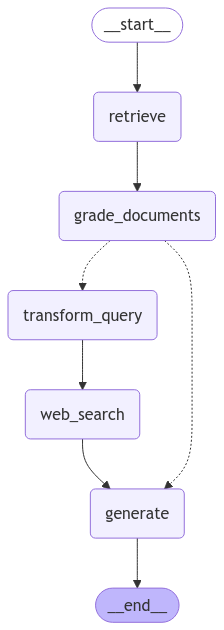

In [92]:
from IPython.display import Image, display

try:
    display(Image(graph_1_crag.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### Flow 2 - Self-RAG

![image.png](attachment:fef27379-03c6-4085-826f-33d3c2070557.png)
[Reference here](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_self_rag/)

In [93]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
graph_2_selfrag = workflow.compile()

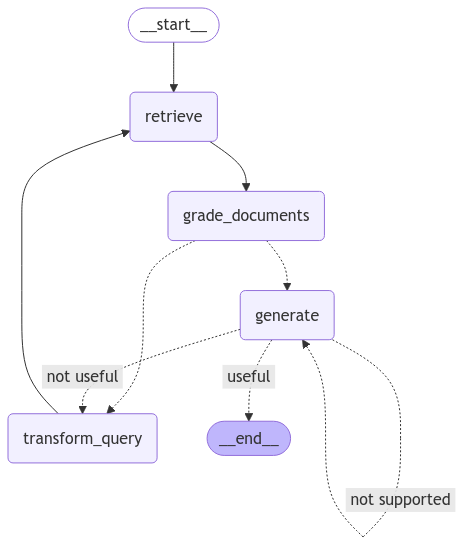

In [94]:
from IPython.display import Image, display

try:
    display(Image(graph_2_selfrag.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### Flow 3 - Corrective RAG (custom) = Corrective RAG + Hallucination + Answer Relevance Checker

In [95]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search")
workflow.add_edge("web_search", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
graph_3_crag_custom = workflow.compile()

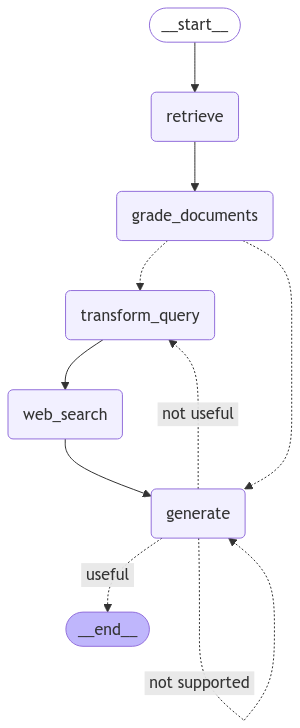

In [96]:
from IPython.display import Image, display

try:
    display(Image(graph_3_crag_custom.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### Flow 4 - Adaptive RAG = Self-RAG + Query Analysis

![image.png](attachment:9079738e-a1ed-4534-bf04-f8d48817dd14.png)
[Reference here](https://python.langchain.com/v0.1/docs/use_cases/query_analysis/)

![image.png](attachment:667874de-699e-4766-b8d9-66da8ac82645.png)
[Reference here](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_adaptive_rag/)

In [97]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search

##STEP 6: adding new node for YouTube search
workflow.add_node("youtube_search", youtube_search_node)

workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query


# Build graph
# set_conditional_entry_point method doesn't require mentioning START
##STEP 7 MODIFY conditional edge for new tool here
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
        "youtube_search" : "youtube_search"
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("youtube_search", "generate")

##STEP 8: ##ADD edge for tool to END if invoking tool returns output /or/ ADD edge like Tavily, which connects to generate
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
graph_4_adaptiverag = workflow.compile()

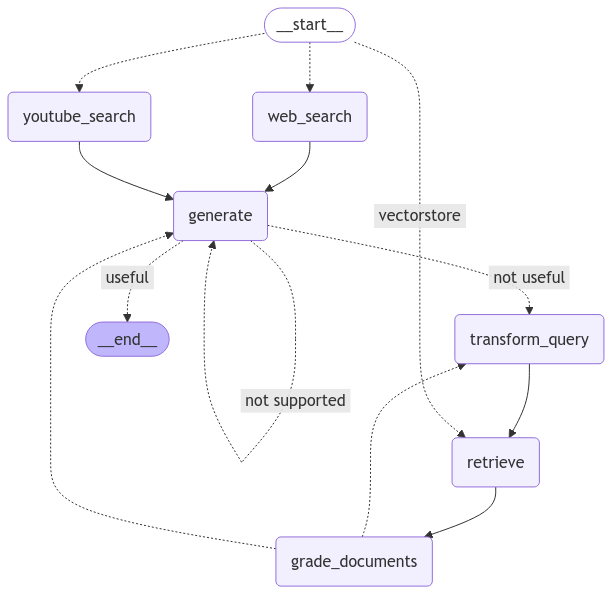

In [98]:
from IPython.display import Image, display

try:
    display(Image(graph_4_adaptiverag.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### Flow 5 - Adaptive RAG (custom) = Corrective RAG (custom) + Query Analysis

In [99]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search", web_search)  # web search

# Build graph
# set_conditional_entry_point method doesn't require mentioning START
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search")
workflow.add_edge("web_search", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
graph_5_adaptiverag_custom = workflow.compile()

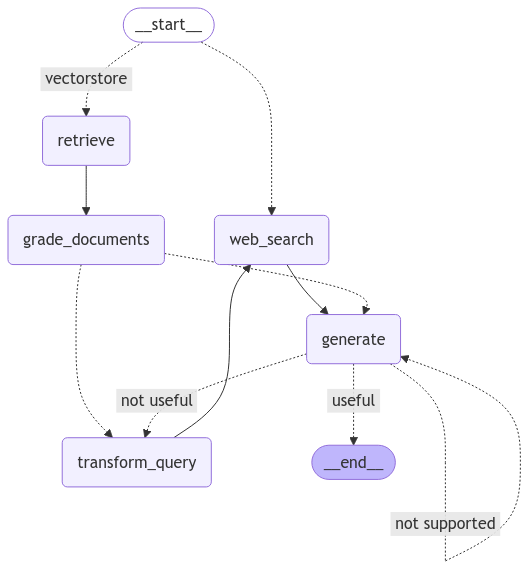

In [100]:
from IPython.display import Image, display

try:
    display(Image(graph_5_adaptiverag_custom.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Use Graph

### For Question Not in Context

In [101]:
question_search

'Which players in IPL 2025 are expected to draw significant bids'

In [102]:
# Run
inputs = {
    "question": question_search
}

In [103]:
#Self-RAG gets stuck in loop!
for i,app in enumerate([graph_1_crag, graph_3_crag_custom, graph_5_adaptiverag_custom]):
    print("FLOW {}----->".format(str(2*i+1))+"\n")
    for output in app.stream(inputs):
        for key, value in output.items():
            # Node
            pprint(f"Node '{key}':")
            # Optional: print full state at each node
            # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
        pprint("\n---\n")

    # Final generation
    pprint(value["generation"])
    print("---"*20 + "\n\n\n")

FLOW 1----->

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('Based on the context, the IPL players who are likely to attract high auction '
 'prices in the 2025 season are Rishabh Pant, Glenn Maxwell, KL Rahul, and '
 'Shreyas Iyer.')
------------------------------------------------------------



FLOW 3----->

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NO

### For Question in Context

In [104]:
question_doc

'What are the highlights of the PGP in Data Science and AI course at Jio Institute'

In [105]:
# Run
inputs = {"question": question_doc}

In [106]:
for i,app in enumerate([graph_1_crag, graph_2_selfrag, graph_3_crag_custom]):
    print("FLOW {}----->".format(str(i+1))+"\n")
    for output in app.stream(inputs):
        for key, value in output.items():
            # Node
            pprint(f"Node '{key}':")
            # Optional: print full state at each node
            # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
        pprint("\n---\n")

    # Final generation
    pprint(value["generation"])
    print("---"*20 + "\n\n\n")

FLOW 1----->

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
("I don't have information on the specific highlights of the PGP in Data "
 'Science and AI course at Jio Institute. The provided context only mentions '
 'the eligibility criteria and a general description of the course, but not '
 'specific highlights.')
------------------------------------------------------------



FLOW 2----->

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents'

In [119]:
##STEP 9 - Test with a relevant question that routes to the YouTube tool

youtube_search_query

'I want few links to good YouTube videos on Generative AI crash course'

In [120]:
# Run
inputs = {"question": youtube_search_query}

In [121]:
# execute the graph

for i,app in enumerate([graph_4_adaptiverag]):
    print("FLOW {}----->".format(str(i+4))+"\n")
    for output in app.stream(inputs):
        for key, value in output.items():
            # Node
            pprint(f"Node '{key}':")
            # Optional: print full state at each node
            # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
        pprint("\n---\n")

    # Final generation
    pprint(value["generation"])
    print("---"*20 + "\n\n\n")

FLOW 4----->

---ROUTE QUESTION---
---ROUTE QUESTION TO YOUTUBE SEARCH---
---YOUTUBE SEARCH---
"Node 'youtube_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Here are a few links to good YouTube videos on a Generative AI crash '
 'course:\n'
 '\n'
 '1. https://www.youtube.com/watch?v=Yq0QkCxoTHM\n'
 '2. https://www.youtube.com/watch?v=OjiTgpDPQbE\n'
 '3. https://www.youtube.com/watch?v=nJ25yl34Uqw\n'
 '\n'
 'These videos appear to provide an introduction to generative AI and its '
 'applications.')
------------------------------------------------------------





## Exercise 4: Executing same query multiple times and recording the traces

In [122]:
# using below query for generating traces
youtube_search_query

'I want few links to good YouTube videos on Generative AI crash course'

In [123]:
# Run
inputs = {
    "question": youtube_search_query
}

In [126]:
# execute the graph

for i,app in enumerate([graph_4_adaptiverag]):
    print("FLOW {}----->".format(str(i+4))+"\n")
    for output in app.stream(inputs):
        for key, value in output.items():
            # Node
            pprint(f"Node '{key}':")
            # Optional: print full state at each node
            # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
        pprint("\n---\n")

    # Final generation
    pprint(value["generation"])
    print("---"*20 + "\n\n\n")

FLOW 4----->

---ROUTE QUESTION---
---ROUTE QUESTION TO YOUTUBE SEARCH---
---YOUTUBE SEARCH---
"Node 'youtube_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Here are a few links to good YouTube videos on Generative AI crash course:\n'
 '\n'
 '* https://www.youtube.com/watch?v=Yq0QkCxoTHM\n'
 '* https://www.youtube.com/watch?v=OjiTgpDPQbE\n'
 '* https://www.youtube.com/watch?v=nJ25yl34Uqw\n'
 '\n'
 'These videos appear to be crash courses on generative AI, covering topics '
 'such as the basics of generative AI, its applications, and how it works.')
------------------------------------------------------------



